In [2]:
library(tidyverse)
library(repr)
library(RColorBrewer)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [ ]:
install.packages('themis')

library(themis)

also installing the dependencies ‘ellipsis’, ‘lifecycle’, ‘pillar’, ‘cli’, ‘glue’, ‘rlang’, ‘tibble’, ‘vctrs’, ‘hardhat’, ‘ipred’, ‘recipes’, ‘generics’, ‘RANN’, ‘ROSE’


Warning message in install.packages("themis"):
“installation of package ‘themis’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
Warning message in readRDS(file):
“error reading the file”


In [ ]:
pulsar_data <- read_csv("https://github.com/kseniak1/DSCI100-Group-Project/raw/main/HTRU_2%5B1%5D.csv", col_names = FALSE) %>%
                rename(mean_ip = X1,
                      dev_ip = X2,
                      excess_ip = X3,
                      skewness_ip = X4,
                      mean_dm = X5,
                      dev_dm = X6,
                      excess_dm = X7,
                      skewness_dm = X8,
                      class = X9) %>%
                mutate(class = as.factor(class))
pulsar_data


In [ ]:
set.seed(19)
random_mean = runif(1, min = 5.8125000, max = 192.617188)
random_excess = runif(1, min = -1.8760112, max = 7.879628)
random_point = tibble(mean_ip = random_mean, excess_ip = random_excess)
random_point

mean_val <- 
plot <- ggplot() +
geom_point(aes(x = random_mean, y = random_excess), color = '#F8766D'/'#619CFF', size = 3)
plot

In [ ]:
balance_pulsar <- pulsar_data %>%
                    sample_n(500) 

In [ ]:
install.packages('ROSE')
library(ROSE)

In [ ]:
set.seed(19)
pulsar <- ovun.sample(class~., data = balance_pulsar, p = 0.5, method = "over")$data
pulsar_nums <- pulsar %>%
                group_by(class) %>%
                summarize(n = n())
pulsar_nums

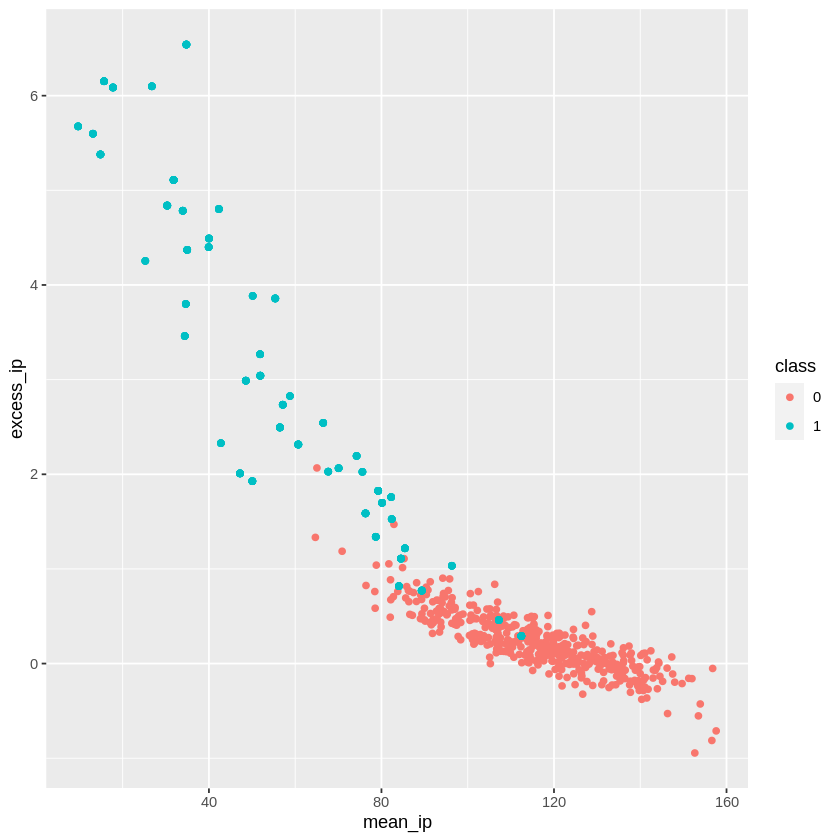

In [37]:
pulsar_plot <- ggplot(pulsar, aes(x = mean_ip, y = excess_ip, color = class)) +
                geom_point()
pulsar_plot

In [38]:
## Copied from Avishka's notebook
set.seed(19)

#Splitting our data

pulsar_split <- initial_split(pulsar, prop = 0.75, strata = class)  
pulsar_training_data <- training(pulsar_split)   
pulsar_testing_data <- testing(pulsar_split)

#Cross validation
pulsar_vfold <- vfold_cv(pulsar_training_data, v = 5, strata = class)

#knn model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

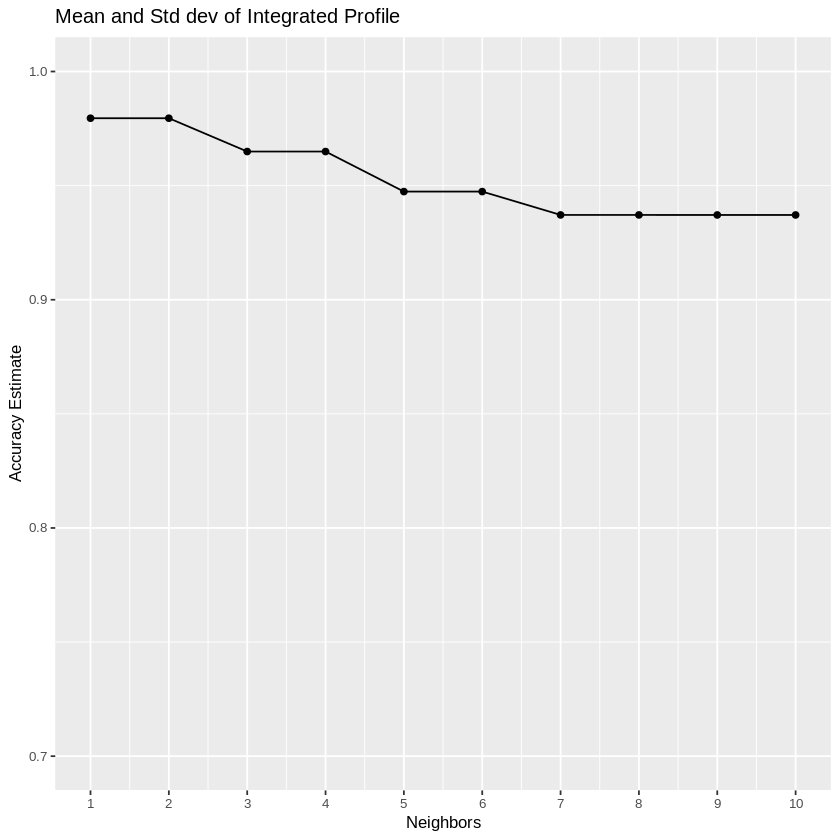

In [39]:
## Copied from Avishka's notebook

set.seed(19)

pulsar_ip_recipe_1 <- recipe(class ~ mean_ip + dev_ip , data = pulsar_training_data) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

k_values_1 <- tibble(neighbors = 1:10)

knn_ip_results_1 <- workflow() %>%
       add_recipe(pulsar_ip_recipe_1) %>%
       add_model(knn_spec) %>%
       tune_grid(resamples = pulsar_vfold, grid = k_values_1) %>%
       collect_metrics() %>%
       filter(.metric == "accuracy")

ip_plot_1 <- ggplot(knn_ip_results_1, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       scale_x_continuous(breaks = seq(0, 10, by = 1)) +
       scale_y_continuous(limits = c(0.7, 1.0)) +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Mean and Std dev of Integrated Profile") +
       theme(text = element_text(size = 10)) 
ip_plot_1

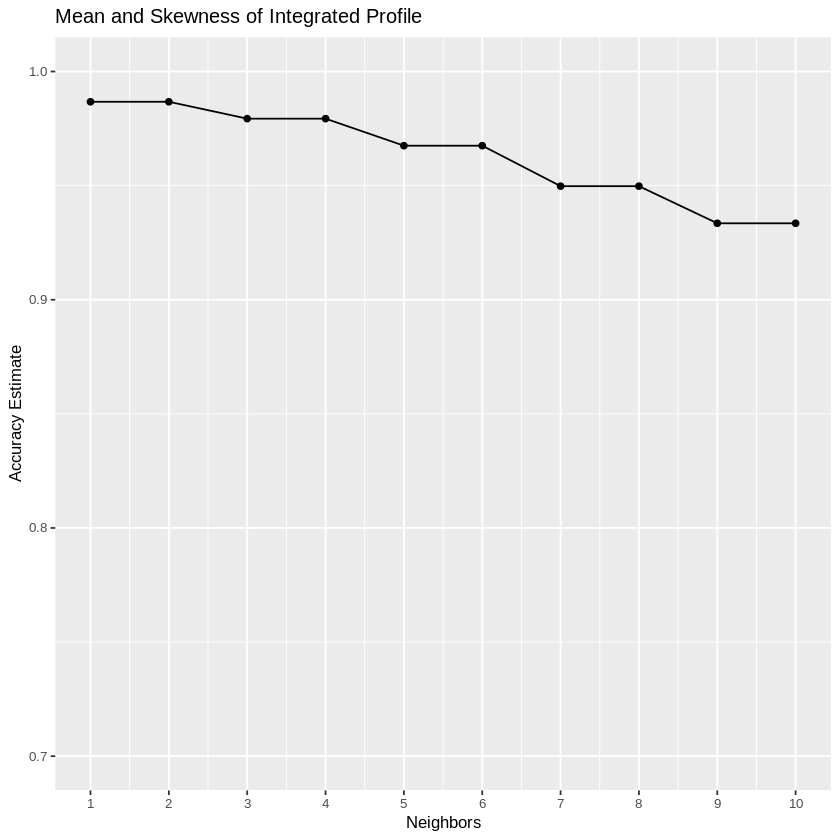

In [32]:
## Copied from Avishka's notebook
set.seed(19)

pulsar_ip_recipe_2 <- recipe(class ~ mean_ip + skewness_ip , data = pulsar_training_data) %>%
     step_scale(all_predictors())%>%
     step_center(all_predictors())

k_values_2 <- tibble(neighbors = 1:10)

knn_ip_results_2 <- workflow() %>%
       add_recipe(pulsar_ip_recipe_2) %>%
       add_model(knn_spec) %>%
       tune_grid(resamples = pulsar_vfold, grid = k_values_2) %>%
       collect_metrics() %>% 
       filter(.metric == "accuracy")

ip_plot_2 <- ggplot(knn_ip_results_2, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       scale_x_continuous(breaks = seq(0, 10, by = 1)) +
       scale_y_continuous(limits = c(0.7, 1.0)) +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Mean and Skewness of Integrated Profile") +
       theme(text = element_text(size = 10)) 
ip_plot_2

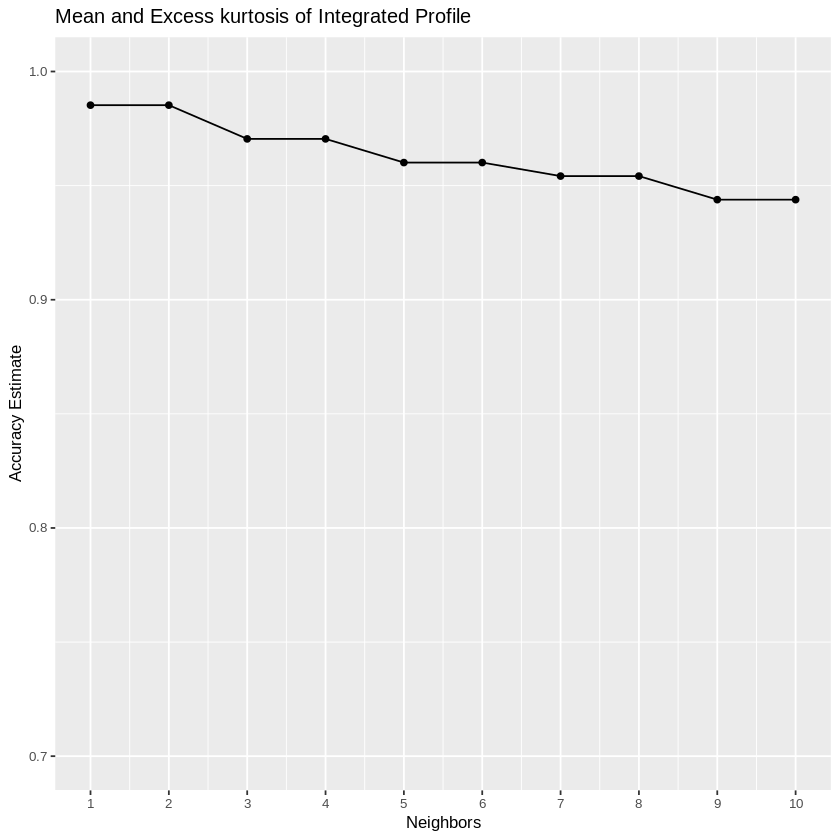

In [34]:
## Copied from Avishka's notebook
set.seed(19)

pulsar_ip_recipe_3 <- recipe(class ~ mean_ip + excess_ip , data = pulsar_training_data) %>%
     step_scale(all_predictors())%>%
     step_center(all_predictors())

k_values_3 <- tibble(neighbors = 1:10)

knn_ip_results_3 <- workflow() %>%
       add_recipe(pulsar_ip_recipe_3) %>%
       add_model(knn_spec) %>%
       tune_grid(resamples = pulsar_vfold, grid = k_values_3) %>%
       collect_metrics() %>% 
       filter(.metric == "accuracy")

ip_plot_3 <- ggplot(knn_ip_results_3, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       scale_x_continuous(breaks = seq(0, 10, by = 1)) +
       scale_y_continuous(limits = c(0.7, 1.0)) +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Mean and Excess kurtosis of Integrated Profile") +
       theme(text = element_text(size = 10)) 
ip_plot_3

In [ ]:
knitr::kable(pulsar, caption = "My data")
pulsar